In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import linspace, polyval, polyfit, sqrt, stats, randn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

/home/alejandro-mc/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
# Import sensor data indexed by Timestamp
sensor_df = pd.read_csv('HHtest.txt', names = ["Sensor", "Seconds", "Timestamp", "Temp", "Rel Humid", "Voltage"],
                        index_col = ['Timestamp'], parse_dates = ["Timestamp"])
# Delete unneeded columns
sensor_df.drop(['Sensor','Seconds','Rel Humid', 'Voltage'], axis = 1, inplace = True)

#sensor_df[:3]

In [3]:
# Resample for every 30 minutes and name according to midpoint
sensor_df = sensor_df.resample('30T', loffset = '-15 min').mean()
#sensor_df.head

In [4]:
# Import sensor data indexed by Timestamp
LGA_df = pd.read_csv('KLGA.csv', names = ["Timestamp", "Temp", "Rel Humid"], index_col = ['Timestamp'], parse_dates = ["Timestamp"])

# Delete unneeded columns
LGA_df.drop(['Rel Humid'], axis = 1, inplace = True)

#LGA_df.head

In [5]:
# Resample for every 30 minutes and name according to midpoint
LGA_df = LGA_df.resample('30T', loffset = '-15 min').mean()
#LGA_df[:3]

In [6]:
date_range = pd.date_range('2016-07-07 14:15:00','2016-09-15 12:45:00', freq='30T')
len(date_range.tolist())

3358

In [38]:
# Join df together for all timestamps that exist in both files

joined_df = LGA_df.join(sensor_df, how = 'inner', lsuffix = '_LGA', rsuffix = '_sensor')

joined_df = joined_df.fillna(method = 'ffill') # drop NaN values **Are the values in order? Do we need to interpolate between the values?
#joined_df = joined_df.resample('30T').pad()
joined_df.head

<bound method DataFrame.head of                       Temp_LGA  Temp_sensor
Timestamp                                  
2016-07-07 14:15:00  85.502857        75.20
2016-07-07 14:45:00  83.920000        78.26
2016-07-07 15:15:00  87.585714        76.82
2016-07-07 15:45:00  85.420000        76.01
2016-07-07 16:15:00  87.714286        74.93
2016-07-07 16:45:00  86.920000        74.12
2016-07-07 17:15:00  84.320000        73.85
2016-07-07 17:45:00  83.920000        73.58
2016-07-07 18:15:00  80.797143        73.31
2016-07-07 18:45:00  78.820000        73.22
2016-07-07 19:15:00  80.282857        73.40
2016-07-07 19:45:00  79.420000        73.04
2016-07-07 20:15:00  79.100000        73.22
2016-07-07 20:45:00  80.320000        72.95
2016-07-07 21:15:00  79.614286        72.77
2016-07-07 21:45:00  78.820000        72.86
2016-07-07 22:15:00  78.842857        73.13
2016-07-07 22:45:00  78.220000        72.59
2016-07-07 23:15:00  77.531429        73.04
2016-07-07 23:45:00  75.520000        72.86


In [8]:
def find_exp_weights():
    # Find exponential weights for the building temperature calculation
    weight_list = []
    tau = 48.0 # decay constant in hours
    for i in range(1,145):
        time_in_hours = (0.5*i) # each dp is a 0.5 hours so this is the t (in hours)
        # time_in_hours = 72 - (0.5*i) # each dp is a 0.5 hours
        weight_i = math.exp(-time_in_hours/tau)
        weight_list.append(weight_i)
    return weight_list

In [9]:
def find_T_building(temp_3day, weight_list):
    #Input first three days of the dataframe of indoor temp data. Computes one Temperature data
    #point (T_building) given data points from the three previous days (temp_3day) 
    #by assigning a weight to each data point and adding them up
    weight_array = np.array(weight_list)
    T_building = np.dot(np.array(temp_3day), weight_array)
    normalized_T_building = T_building / sum(weight_list)
    return normalized_T_building

In [10]:
def find_T_average(temp_3day):
    #Input first three days of the dataframe of indoor temp data...
    Tsum = np.sum(np.array(temp_3day))
    T_average = Tsum / len(temp_3day)
    return T_average

In [11]:
temp_sens_array = np.array(joined_df['Temp_sensor'])
temp_sens = joined_df['Temp_sensor']

def create_Tr_averages(temp_sens):
    T_average_list = []
    T_average_index = []
    dt = pd.DateOffset(days = 3) # 3 days 

    for j in range(144,len(temp_sens)): 
        #144 points in the first 3 days (because 72 hours * 2 dp/hr)
        Timestamp_j = temp_sens.index[j]
        temp_3day = temp_sens[Timestamp_j-dt :Timestamp_j-1]
        T_average = find_T_average(temp_3day)
        T_average_list.append(T_average)
        T_average_index.append(Timestamp_j)
    
    return pd.Series(T_average_list, index = T_average_index, name = 'T_building')


In [12]:
temp_3day = temp_sens[0: 144]
find_T_average(temp_3day)
T_average = create_Tr_averages(temp_sens)
print len(T_average)

3214


In [13]:
temp_sens_array = np.array(joined_df['Temp_sensor'])
temp_sens = joined_df['Temp_sensor']

def create_T_building_series(temp_sens):
    T_building_list = []
    T_building_index = []
    dt = pd.DateOffset(days = 3) # 3 days 
    weight_list = find_exp_weights()

    for j in range(144,len(temp_sens)): 
        #144 points in the first 3 days (because 72 hours * 2 dp/hr)
        Timestamp_j = temp_sens.index[j]
        temp_3day = temp_sens[Timestamp_j-dt :Timestamp_j-1]

        T_building = find_T_building(temp_3day, weight_list)
        T_building_list.append(T_building)
        T_building_index.append(Timestamp_j)
    
    return pd.Series(T_building_list, index = T_building_index, name = 'T_building')


In [14]:
T_building_series = create_T_building_series(temp_sens)
print len(T_building_series)
T_building_series[:3]

3214


2016-07-10 14:15:00    74.523058
2016-07-10 14:45:00    74.529504
2016-07-10 15:15:00    74.494772
Name: T_building, dtype: float64

In [15]:
#joined_df = joined_df.join(T_building_series, how = 'inner')
joined_df2 = pd.concat([joined_df,T_building_series], axis=1, join ='inner')
print joined_df2.index[len(joined_df2)-1]
print len(joined_df2)
joined_df2[:3]

2016-09-15 12:45:00
3214


,Temp_LGA,Temp_sensor,T_building
2016-07-10 14:15:00,80.226667,79.7,74.523058
2016-07-10 14:45:00,80.226667,79.7,74.529504
2016-07-10 15:15:00,77.973333,79.7,74.494772


In [16]:
# Import solar historical data indexed by Timestamp
# Radiation data is reported in W/m^2
solar_df = pd.read_csv('histsolar.txt', names = ["Timestamp", "Solar"],
                        index_col = ['Timestamp'], parse_dates = ["Timestamp"])


In [17]:
solar_df = solar_df.resample('30T', loffset = '-15 min').mean()
#solar_df = solar_df[joined_df2.index[0],joined_df2.index[len(joined_df2)-1]]
print solar_df.index[len(solar_df)-1]
solar_df[:3]

2016-09-15 23:15:00


,Solar
Timestamp,
2016-07-06 23:45:00,0.0
2016-07-07 00:15:00,0.0
2016-07-07 00:45:00,0.0


In [18]:
joined_df2 = joined_df2.join(solar_df, how = 'left', lsuffix = '_joined', rsuffix = '_solar')
print(len(joined_df2))
joined_df2 = joined_df2.fillna(method = 'ffill')
joined_df2.head

3214


<bound method DataFrame.head of                       Temp_LGA  Temp_sensor  T_building       Solar
2016-07-10 14:15:00  80.226667        79.70   74.523058  320.166667
2016-07-10 14:45:00  80.226667        79.70   74.529504  420.000000
2016-07-10 15:15:00  77.973333        79.70   74.494772  400.800000
2016-07-10 15:45:00  77.020000        79.70   74.479086  429.833333
2016-07-10 16:15:00  77.196667        79.70   74.474153  523.000000
2016-07-10 16:45:00  77.196667        79.70   74.483726  216.500000
2016-07-10 17:15:00  79.440000        79.79   74.504316  195.400000
2016-07-10 17:45:00  79.440000        79.88   74.529032  196.000000
2016-07-10 18:15:00  78.873333        79.88   74.557916   89.500000
2016-07-10 18:45:00  78.820000        79.70   74.590743  173.600000
2016-07-10 19:15:00  78.997143        79.79   74.624584   43.666667
2016-07-10 19:45:00  78.820000        79.79   74.656625   51.333333
2016-07-10 20:15:00  78.200000        79.70   74.693853    1.400000
2016-07-10 20:45

In [19]:
joined_df2.isnull().values.any()

False

In [20]:
Ta = joined_df2.iloc[:,0].values # creates np array for ambient temp
Tr = joined_df2.iloc[:,1].values # creates np array for resident temp
Tb = joined_df2.iloc[:,2].values # creates np array for building storage temp
Ti = 0.5*Tr + 0.5*Ta # window temperature for radiation calcs

In [21]:
#Ta = np.transpose(Ta)
Ta = np.matrix(joined_df2.iloc[:,0].values) # creates np array for ambient temp
Tr = np.matrix(joined_df2.iloc[:,1].values) # creates np array for resident temp
Tb = np.matrix(joined_df2.iloc[:,2].values) # creates np array for building storage temp
Ti = 0.5*Tr + 0.5*Ta # window temperature for radiation calcs
Tb.shape

(1, 3214)

In [22]:
x1 = Tb-Tr # var1: conduction between building and the residence
x2 = Ta-Tr # var2: conduction between building and the outdoors
# x3 =  # var3: conduction with windspeed to account for convection
x4 = np.matrix(joined_df2.iloc[:,3].values) # var4: solar radiation (np array)
#x5 = 
x6 = np.power(Ti, 4) # var6 radiation from the window
x7 = np.power(Tr, 4) # var7 for radiation


In [23]:
x1.shape

(1, 3214)

In [24]:
X = np.concatenate((x1.T, x2.T, x4.T, x6.T, x7.T), axis=1) # Combine vars into vars vector X
X = np.delete(X,0,0)
X = np.multiply(X, 0.5) # multiply by 0.5 hours
X.shape

(3213, 5)

In [25]:
T_average = np.matrix(T_average)
T_average.shape

(1, 3214)

In [26]:
T_old_mat = np.delete(Tr,len(Tr),1)
T_old_mat = np.delete(T_average,len(T_average)-1,1)
T_new = np.delete(Tr,0,1)
y = (T_new - T_old_mat).T
y.shape

(3213, 1)

In [27]:
joined_df2[:3]

,Temp_LGA,Temp_sensor,T_building,Solar
2016-07-10 14:15:00,80.226667,79.7,74.523058,320.166667
2016-07-10 14:45:00,80.226667,79.7,74.529504,420.000000
2016-07-10 15:15:00,77.973333,79.7,74.494772,400.800000


In [28]:
# create training and testing vars
testsize = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(2891, 5) (2891, 1)
(322, 5) (322, 1)


In [29]:
# multivariable linear regression
regr = linear_model.LinearRegression()
model = regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
#mult_regr.predict(LGA_data[:20]).shape
coefficients = model.coef_
print coefficients
regr.score(X_test,y_test)


[[ -1.61728479e+00   7.46676529e-02  -3.81019736e-04  -4.41611756e-08
    3.28101290e-08]]


0.98578671147794805

In [34]:
print y_test.shape
print predictions.shape

(322, 1)
(322, 1)


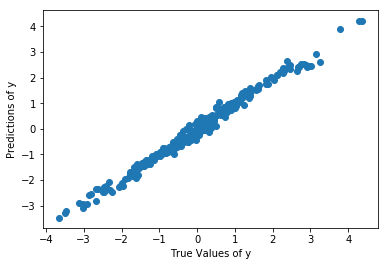

In [35]:
## The line / model
plt.scatter(list(y_test), list(predictions))
plt.xlabel('True Values of y')
plt.ylabel('Predictions of y')

In [39]:
# multivariable linear regression
regr = linear_model.LinearRegression()
model = regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
coefficients = model.coef_
regr.score(X_test,y_test)
#[k1, k2, k4, k6, k7] = model.coef_[0]

0.98578671147794805

In [40]:
#temp_3day = temp_sens[0: 144]
#find_T_average(temp_3day)
T_average = create_Tr_averages(temp_sens)


In [41]:
def apply_model(Tr_now, Ta_now, T_average_now, Tb_now, solar_now, coefficients):
    [k1, k2, k4, k6, k7] = coefficients[0]
    X1 = Tb_now - Tr_now
    X2 = Ta_now - Tr_now
    X4 = solar_now
    Ti_now = 0.5*Ta_now + 0.5*Tr_now
    X6 = Ti_now**4
    X7 = Tr_now**4
    T_new = T_average_now + k1*X1*0.5 + k2*X2*0.5 + k4*X4*0.5 + k6*X6*0.5 +k7*X7*0.5 # make sure to multiply by delta_t***
    return T_new
    
    

In [42]:
Tr_list = joined_df2['Temp_sensor'].values.tolist()[0:144]
Ta_list = joined_df2['Temp_LGA'].values.tolist()[143:] # includes current so there is an overlap point with Tr_list
Tr_future_list = joined_df2['Temp_sensor'].values.tolist()[144:]
sol_list = joined_df2['Solar'].values.tolist()[143:]
len(Tr_future_list)

3070

In [43]:
temp_sens_array = np.array(joined_df['Temp_sensor'])
temp_sens = joined_df['Temp_sensor']

def create_Tr_averages(temp_sens):
    T_average_list = []
    T_average_index = []
    dt = pd.DateOffset(days = 3) # 3 days 

    for j in range(144,len(temp_sens)): 
        #144 points in the first 3 days (because 72 hours * 2 dp/hr)
        Timestamp_j = temp_sens.index[j]
        temp_3day = temp_sens[Timestamp_j-dt :Timestamp_j-1]
        T_average = find_T_average(temp_3day)
        T_average_list.append(T_average)
        T_average_index.append(Timestamp_j)
    
    return pd.Series(T_average_list, index = T_average_index, name = 'T_average')

In [44]:
def find_T_average(temp_3day):
    #Input first three days of the dataframe of indoor temp data...
    Tsum = np.sum(np.array(temp_3day))
    T_average = Tsum / len(temp_3day)
    return T_average

In [45]:
def predict_T_new(temp_3day, weight_list, future_sol, future_Ta, coefficients, N):
    # temp_3day should include current temp
    # future sol and Ta are the vals for the prediction (includes current)
    # N is the number of values to be predicted into the future
    #Tr_now = temp_3day[len(temp_3day)-1]
    predicted_Tr = []
    previous_temps = temp_3day.tolist()
    #error_list = []
    
    for i in range(N):
        Tr_now = previous_temps[len(previous_temps)-1]
        T_average_now = find_T_average(previous_temps)
        Tb_now = find_T_building(previous_temps, weight_list)
        solar_now = future_sol[i]
        Ta_now = future_Ta[i]
        predict = apply_model(Tr_now, Ta_now, T_average_now, Tb_now, solar_now, coefficients)
        predicted_Tr.append(predict)
        previous_temps.pop(0)
        previous_temps.append(predict)
        
        #error = (Tr_future_list[i]-predict)/Tr_future_list[i]
        #error_list.append(error)
        
    return predicted_Tr
    

In [46]:
dt = pd.DateOffset(days = 3) # 3 days 
j = 144
Timestamp_j = temp_sens.index[j]
temp_3day = temp_sens[Timestamp_j-dt :Timestamp_j-1]
#temp_3day.index.get_loc(temp_3day.index[0])
weight_list = find_exp_weights()
future_sol = sol_list
future_Ta = Ta_list
N = 3070
T_new = predict_T_new(temp_3day, weight_list, future_sol, future_Ta, coefficients, N)
#np.asarray(T_new).shape

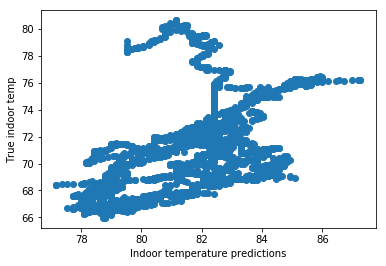

In [47]:
## The line / model
plt.scatter(Tr_future_list, T_new)
plt.xlabel('Indoor temperature predictions')
plt.ylabel('True indoor temp')

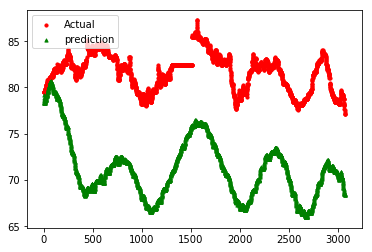

In [48]:
t = range(3070)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(t, Tr_future_list, s=10, c='r', marker="o", label='Actual')
ax1.scatter(t,T_new, s=10, c='g', marker="^", label='prediction')
plt.legend(loc='upper left');
plt.show()

In [49]:
r2_score(Tr_future_list, T_new)

-29.574591989150026

In [42]:
given_vars_df = joined_df2.drop(['Temp_sensor','T_building'], axis = 1)
given_test_df = given_vars_df[int(round(testsize*3214)):]

given_test_df[:3]

,Temp_LGA,Solar
2016-07-17 06:45:00,78.820000,86.000000
2016-07-17 07:15:00,78.714286,84.200000
2016-07-17 07:45:00,78.820000,146.833333


In [43]:
# TRYING WITHOUT THE CHEATING!
# multivariable linear regression
regr = linear_model.LinearRegression()
model = regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
#mult_regr.predict(LGA_data[:20]).shape
#coefficients = regr_fit.coef_
regr.score(X_test,y_test)

0.98677515115184899

In [44]:
int(round(testsize*3214))

321

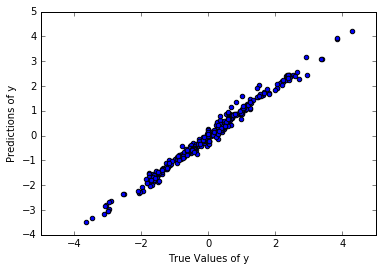

In [45]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values of y')
plt.ylabel('Predictions of y')

In [46]:
# Linear regression using linear_model from sklearn 
#TempLGA = np.transpose(np.matrix(joined_df['Temp_LGA']))
#Tempsensor = np.transpose(np.matrix(joined_df['Temp_sensor']))

regr = linear_model.LinearRegression()
regr.fit(TempLGA, Tempsensor)
#regr.score(X,y) # Why?!:ValueError: shapes (765,6) and (1,1) not aligned: 6 (dim 1) != 1 (dim 0) 

#z = polyfit(TempLGA, Tempsensor, 4) # polyfit for fitting
#p = np.poly1d(z) #polynomial of fit

NameError: name 'TempLGA' is not defined

In [ ]:
TempLGA = np.transpose(np.matrix(joined_df['Temp_LGA']))
Tempsensor = np.transpose(np.matrix(joined_df['Temp_sensor']))


In [ ]:
temp_sens.index[0]

In [ ]:
#Plot all data wrt time
fig_size = np.array(mpl.rcParams['figure.figsize']) # size of plot
fig_size *=2 # increase size of plot
#joined_df.plot(figsize = fig_size) # plot data

In [ ]:
plt.plot()
plt.plot(TempLGA, Tempsensor, '.', TempLGA, regr.predict(TempLGA))
#plt.plot(TempLGA, Tempsensor, '.', TempLGA, p(TempLGA), '--')


In [ ]:
TempLGA_arr = np.array(joined_df['Temp_LGA'][:30])
Tempsensor_arr = np.array(joined_df['Temp_sensor'][:30])
pd.rolling_corr(TempLGA_arr, Tempsensor_arr, 10).plot()